In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as nla
import scipy
from scipy.linalg import blas
from sklearn.datasets import load_svmlight_file
import time
from timeit import timeit
import csv
import pandas as pd

In [14]:
def ls(A, b, x):
    Ax = A@x
    f = 0.5*np.linalg.norm(Ax - b)**2 
    g = A.T.dot(Ax - b)
    return f, g

class LogisticRegression:
    """
    f(x) = sum_{i=1}^m log(1 + exp(-b_i*(ai'*x))) + 0.5*alpha*||x||^2 with ai in R^n, bi in R
    """

    def __init__(self, A, b, alpha=0):
        assert len(b) == A.shape[0], "Logistic Regression: len(b) != m"
        assert alpha >= 0., "Logistic Regression: regularizer must nonnegative"
        self.bA = np.reshape(b, [len(b), 1]) * A
        self.m = A.shape[0]
        self.n = A.shape[1]
        self.reg = alpha

    def __call__(self, x):
        return self.func_grad(x, flag=0)

    def gradient(self, x):
        return self.func_grad(x, flag=1)

    def func_grad(self, x, flag=2):
        assert x.size == self.n, "Logistic Regression: x.size not equal to n"

        bAx = np.dot(self.bA, x)

        loss = - bAx
        mask = bAx > -50
        loss[mask] = np.log(1. + np.exp(-bAx[mask]))
        f = np.sum(loss) + 0.5 * self.reg * x.dot(x)

        if flag == 0:
            return f

        p = -1. / (1. + np.exp(bAx))
        g = np.dot(p, self.bA) + self.reg * x

        if flag == 1:
            return g

        return f, g

def l1_prox(x0, lmbda):
    return (x0 - lmbda) * (x0 >= lmbda) + (x0 + lmbda) * (x0 <= -lmbda)

def gradient_descent(x0, max_iters, step, f, proj=lambda x: x, linesearch=False, max_step=1.,
                     ls_ratio=2, ls_adapt=True, verbose=False, verbskip=1, max_runtime=100, stop_eps=0.):

    if verbose:
        print("\nGradient descent method with backtracking linesearch")
        print("     k      F(x)     ")

    Fx = np.zeros(max_iters)
    Tx = np.zeros(max_iters)

    x = x0
    runtime = 0.0

    for k in range(max_iters):
        start = time.time()
        fx, g = f.func_grad(x)
        Fx[k] = fx

        if linesearch:
            x1 = proj(x - step * g)
            while f(x1) > fx + np.dot(g, x1 - x) + 0.5 * nla.norm(x1 - x)**2 / step:
                step = step / ls_ratio
                x1 = proj(x - step * g)
            x = x1
            
            if ls_adapt:
                step = max(step * ls_ratio, max_step)
                # step = min(step * ls_ratio, max_step)
        else:
            x = proj(x - step * g)
        
        runtime += time.time() - start
        Tx[k] = runtime

        if verbose and k % verbskip == 0:
            print("{0:6d}  {1:10.6f} ".format(k, Fx[k]))

        # stopping criteria
        if runtime > max_runtime:
            break

        if k > 0 and abs(Fx[k] - Fx[k - 1]) < stop_eps:
            break

    Fx = Fx[0:k + 1]
    Tx = Tx[0:k + 1]
    return x, Fx, Tx

def accelerated_proximal_descent(init, max_iters, step, f, proximal=lambda x: x,
                                 strongcvx=0, opt_coeff=0, restart=False, max_runtime=10, stop_eps=0.):

    Tx = np.zeros(max_iters)
    Fx = np.zeros(max_iters)

    # initialization
    x_current = init

    y_current = x_current
    t_current = 1.0

    # history
    runtime = 0.0

    for k in range(max_iters):

        # history
        Fx[k] = f(y_current)
        # Fx[k] = f(x_current)

        start = time.time()
        # gradient update
        if strongcvx:
            x_next = proximal(y_current - step * f.gradient(y_current))
            y_next = x_next + opt_coeff * (x_next - x_current)
        else:
            x_next = proximal(y_current - step * f.gradient(y_current))
            t_next = .5 * (1 + np.sqrt(1 + 4 * (t_current**2)))
            y_next = x_next + (t_current - 1.0) / \
                (t_next) * (x_next - x_current)
            t_current = t_next

        runtime += time.time() - start
        Tx[k] = runtime

        if runtime > max_runtime:
            break

        # relative error stoping condition
        if nla.norm(x_next - x_current) <= stop_eps * nla.norm(x_current):
            break

        x_current = x_next
        y_current = y_next

        if restart:
            if k > 0 and Fx[k] > Fx[k-1]:
                # if np.dot(g, x - x_1) > 0:
                t_current = 1.0     # reset theta = 1 for updating with equality
                y_current = x_current
    Fx = Fx[0:k + 1]
    Tx = Tx[0:k + 1]
    return x_current, Fx, Tx
     

In [15]:
data_name = "diabetes"
A, b = load_svmlight_file("data/"+data_name)
A = A.toarray()
m, n = A.shape
logreg = LogisticRegression(A,b)
L2norm = nla.norm(A, ord=2)
L2 = L2norm**2/4


In [16]:
m,n

(768, 8)

In [142]:
step = 1.0 / L2;
# step = 1.0
x0 = np.zeros(n);
xs, Fx, _ = gradient_descent(x0, max_iters=101, step=step, f=logreg, linesearch=False, max_step=10.0,
                     ls_ratio=2.0, ls_adapt=True, verbose=True, verbskip=1, max_runtime=100)
# xs_nes, Fx_nes, _ = accelerated_proximal_descent(x0, max_iters=1001, step=step, f=logreg, restart=False, max_runtime=10)



Gradient descent method with backtracking linesearch
     k      F(x)     
     0  478.271555 
     1  363.003852 
     2  315.104656 
     3  289.522008 
     4  274.295034 
     5  264.469066 
     6  257.738771 
     7  252.914948 
     8  249.331735 
     9  246.591485 
    10  244.444239 
    11  242.726235 
    12  241.326469 
    13  240.167530 
    14  239.194112 
    15  238.365876 
    16  237.652860 
    17  237.032455 
    18  236.487357 
    19  236.004149 
    20  235.572313 
    21  235.183511 
    22  234.831072 
    23  234.509607 
    24  234.214732 
    25  233.942845 
    26  233.690972 
    27  233.456634 
    28  233.237755 
    29  233.032583 
    30  232.839632 
    31  232.657633 
    32  232.485497 
    33  232.322284 
    34  232.167177 
    35  232.019467 
    36  231.878530 
    37  231.743817 
    38  231.614843 
    39  231.491178 
    40  231.372437 
    41  231.258275 
    42  231.148385 
    43  231.042486 
    44  230.940326 
    45  230.841675 
    

In [30]:
np.random.seed(12345)
m = 10000
n = 10000
x = np.random.randn(n)
y = np.random.randn(m)
A = np.random.randn(m, n)
def rundot():
    # a = np.dot(x, y)
    # b = np.linalg.norm(x)
     y = np.dot(A, x) 
def rungemv():
    y = blas.dgemv(alpha=1.0, a=A.T, x=x, trans=True)
# y1 = blas.dgemv(alpha=1.0, a=A, x=x)
# y2 = np.dot(A, x) 

In [75]:
m, n = 50, 50
sigmoid = lambda x: 1. / (1. + np.exp(-x))
# np.random.seed(100)

xopt = np.array([1, 0.5, -0.5] + [0]*(n - 3))
A = np.random.randn(m, n)
b = np.round(sigmoid(A @ xopt + np.random.randn(m)*0.0))


In [166]:
import cvxpy as cvx
x = cvx.Variable(n)
loss = cvx.sum(cvx.logistic(-cvx.multiply(b, A @ x))) 

problem = cvx.Problem(cvx.Minimize(loss))
problem.solve(verbose=True, max_iters=1000, abstol=1e-5, reltol=1e-6, feastol=1e-6) 
opt = problem.value
print('Optimal Objective function value is: {}'.format(opt))

e-06  3e-04  9e-06  2e-07  0.4010  9e-01   1  1  1 | 15  4
192  +5.514e+03  +5.513e+03  +8e-02  2e-06  3e-04  9e-06  2e-07  0.9791  1e+00   2  1  1 | 22  0
193  +5.514e+03  +5.513e+03  +8e-02  2e-06  3e-04  9e-06  2e-07  0.5013  9e-01   2  1  1 | 15  3
194  +5.514e+03  +5.513e+03  +7e-02  2e-06  3e-04  8e-06  2e-07  0.9791  1e+00   1  1  0 | 23  0
195  +5.514e+03  +5.513e+03  +7e-02  2e-06  3e-04  8e-06  2e-07  0.4010  8e-01   1  1  1 | 13  4
196  +5.514e+03  +5.513e+03  +7e-02  2e-06  3e-04  8e-06  2e-07  0.9791  1e+00   2  1  0 | 26  0
197  +5.514e+03  +5.513e+03  +6e-02  2e-06  3e-04  8e-06  2e-07  0.4010  9e-01   1  1  0 | 14  4
198  +5.514e+03  +5.513e+03  +6e-02  2e-06  3e-04  8e-06  2e-07  0.9791  1e+00   2  1  1 | 26  0
199  +5.514e+03  +5.513e+03  +6e-02  2e-06  3e-04  7e-06  2e-07  0.4010  9e-01   2  1  1 | 14  4
200  +5.514e+03  +5.513e+03  +6e-02  2e-06  3e-04  7e-06  2e-07  0.9791  1e+00   2  0  1 | 23  0
201  +5.514e+03  +5.513e+03  +6e-02  1e-06  3e-04  7e-06  2e-07  0.4

Text(0, 0.5, 'Objective value')

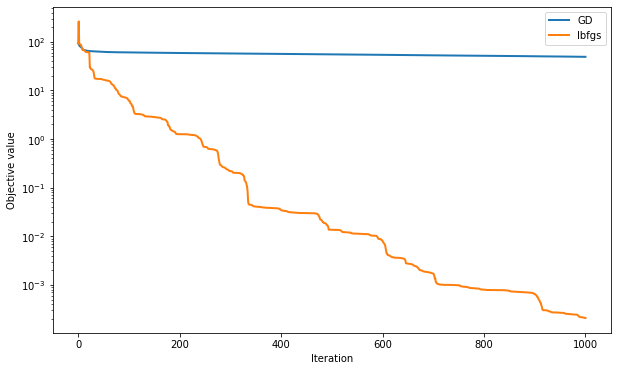

In [40]:
filenames = [ 'heart_gradient_descent_linesearch_initstep0.000037_maxstep10.csv',
              'heart_lbfgs_memory_5.csv',
            ];
dataset = "heart"
labels = ['GD', 'lbfgs', 'AGD', 'GD-BB']
colors = ['C0', 'C1', 'C2', 'C3', 'C4']
markers = ['', '', '']
fig1 = plt.figure(figsize=(10, 6))
optval = 93.81422808691788

for i in range(len(filenames)):
    k = []; t = []; fx = []; 
    with open("output/" + filenames[i]) as csvfile:
        csvReader = csv.reader(csvfile, delimiter=",")
        next(csvReader)  # skip the header
        for row in csvReader:
            k.append(int(row[0]))
            t.append(float(row[1])/60)
            fx.append(float(row[2]))

        plt.plot(k, [f - optval for f in fx], color=colors[i], marker=markers[i], label=labels[i], linewidth=2)

# plt.plot(range(K), [f - optval for f in Fx[0:K]], c='C3', label='GD-PY', linewidth=2)
# plt.plot(range(K), [f - optval for f in Fx_nes[0:K]], marker='.', color='C5', label='Nes-PY', linewidth=1)
plt.yscale('log')
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Objective value")

Text(0, 0.5, 'Objective value')

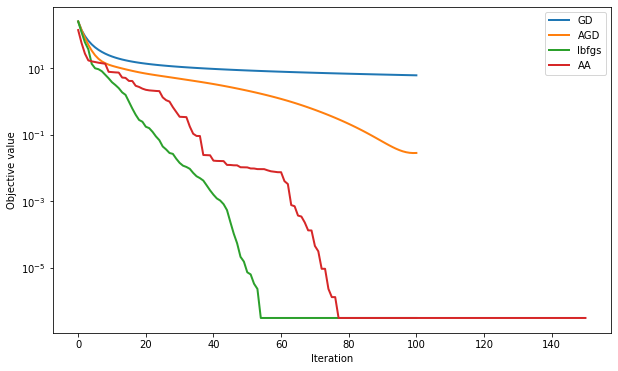

In [153]:
filenames = [ 'australian_gradient_descent_constant_0.001375.csv',
              'australian_nesterov_constant_0.001375.csv',
              'australian_lbfgs_memory_5.csv',
              'australian_anderson_memory10_step0.001375.csv'
            ];
dataset = "australian"
labels = ['GD', 'AGD', 'lbfgs', 'AA']
colors = ['C0', 'C1', 'C2', 'C3']
markers = ['', '', '', '']
fig1 = plt.figure(figsize=(10, 6))
optval = 221.77991469154892

for i in range(len(filenames)):
    k = []; t = []; fx = []; 
    with open("output/" + filenames[i]) as csvfile:
        csvReader = csv.reader(csvfile, delimiter=",")
        next(csvReader)  # skip the header
        for row in csvReader:
            k.append(int(row[0]))
            t.append(float(row[1])/60)
            fx.append(float(row[2]))

        plt.plot(k, [f - optval for f in fx], color=colors[i], marker=markers[i], label=labels[i], linewidth=2)

# plt.plot(range(K), [f - optval for f in Fx[0:K]], c='C3', label='GD-PY', linewidth=2)
# plt.plot(range(K), [f - optval for f in Fx_nes[0:K]], marker='.', color='C5', label='Nes-PY', linewidth=1)
plt.yscale('log')
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Objective value")

Text(0, 0.5, 'Objective value')

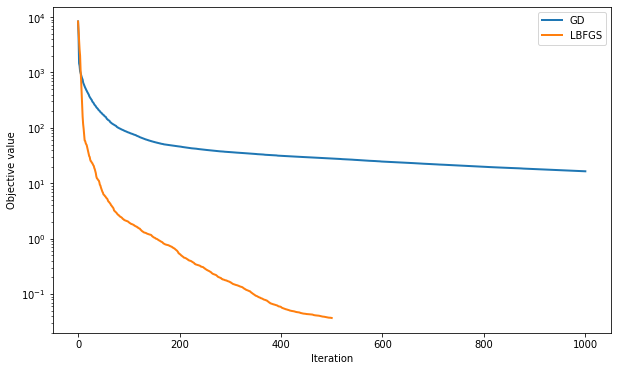

In [41]:
filenames = [ 'a8a_gradient_descent_linesearch_initstep1.000000_maxstep10.csv',
              'a8a_lbfgs_memory_10.csv',
            ];
labels = ['GD', 'LBFGS', 'AGD', 'GD-BB']
colors = ['C0', 'C1', 'C2', 'C3', 'C4']
markers = ['', '', '']
fig1 = plt.figure(figsize=(10, 6))
optval = 7393.417785286414

for i in range(len(filenames)):
    k = []; t = []; fx = []; 
    with open("output/" + filenames[i]) as csvfile:
        csvReader = csv.reader(csvfile, delimiter=",")
        next(csvReader)  # skip the header
        for row in csvReader:
            k.append(int(row[0]))
            t.append(float(row[1])/60)
            fx.append(float(row[2]))

        plt.plot(k, [f - optval for f in fx], color=colors[i], marker=markers[i], label=labels[i], linewidth=2)

# plt.plot(range(K), [f - optval for f in Fx[0:K]], c='C3', label='GD-PY', linewidth=2)
# plt.plot(range(K), [f - optval for f in Fx_nes[0:K]], marker='.', color='C5', label='Nes-PY', linewidth=1)
plt.yscale('log')
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Objective value")

In [2]:
optvals = {"heart": 93.81422808691788, "a8a": 7393.417785286414, "australian": 221.77991469154892,
            "diabetes": 467.3263996820044, "dna": 2.0458784077101627e-07, "mushrooms": 2.2812639469391545e-07, 
            "gisette": 0.0, "w8a": 5512.7413106918475, "real-sim": 0}
algos = ["admm", "anderson_admm", "aapomo", "appa"]
labels = ["admm", "anderson", "aapomo", "appa"]
colors = ['C3', 'C0', 'C1', 'C2']


Text(0, 0.5, 'Objective value')

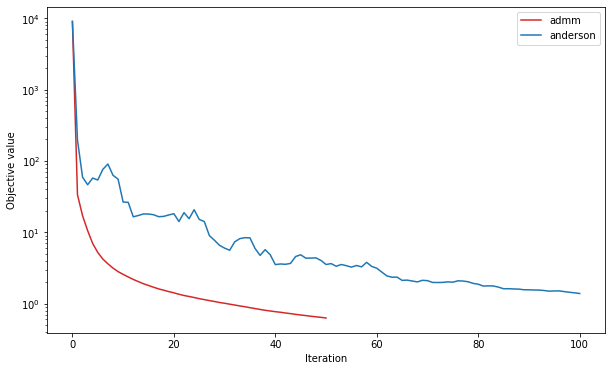

In [14]:
dataset = "a8a"
optval  = optvals[dataset]
fig1 = plt.figure(figsize=(10, 6))
nprocs = 4;
rho = '{:6f}'.format(1)
for idx in range(len(algos)-2):
    k = []; t = []; 
    f = []; feas = []
    with open("output/"+dataset+ "_" + algos[idx] +"_nprocs"+str(nprocs)+"_rho"+str(rho)+".csv") as csvfile:
        csvReader = csv.reader(csvfile, delimiter=",")
        next(csvReader)  # skip the header
        for row in csvReader:
            k.append(int(row[0]))
            t.append(float(row[1])/60)
            f.append(float(row[2]))
            feas.append(float(row[3]))
    
    plt.plot(k, [f - optval for f in f], color=colors[idx], label=labels[idx])
    # plt.plot(t, [f - optval for f in f], color=colors[idx], label=labels[idx])
    # plt.plot(k, [fe for fe in feas], color=colors[idx], label=labels[idx])
plt.yscale('log')
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Objective value")

Text(0, 0.5, 'Relative Speed-up')

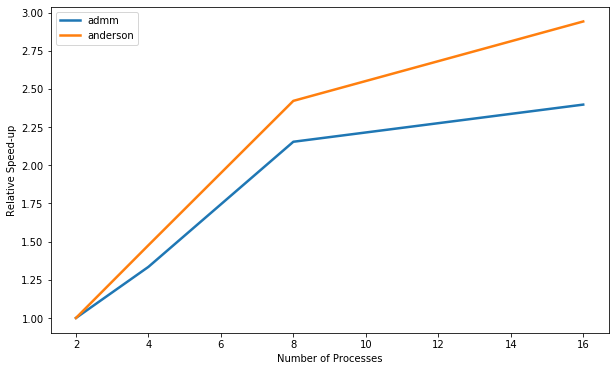

In [17]:
dataset = "real-sim"
optval  = optvals[dataset]
algos = ["admm", "anderson_admm"]
labels = ["admm", "anderson"]
colors = ['C0', 'C3', 'C2', 'C3']
fig1 = plt.figure(figsize=(10, 6))
nprocs = [2, 4, 8, 16];
mean   = np.zeros((len(algos), len(nprocs)))

for idx in range(len(algos)):
    for proc_idx in range(len(nprocs)):
        k = []; t = []; 
        f = []; feas = []
        with open("output/"+dataset+ "_" + algos[idx] +"_nprocs"+str(nprocs[proc_idx])+"_rho1.000000"".csv") as csvfile:
            csvReader = csv.reader(csvfile, delimiter=",")
            next(csvReader)  # skip the header
            for row in csvReader:
                k.append(int(row[0]))
                t.append(float(row[1])/60)
                f.append(float(row[2]))
                feas.append(float(row[3]))
        mean[idx, proc_idx] = t[-1];        

    plt.plot(nprocs, mean[idx, 0] / mean[idx, :], label=labels[idx], linewidth=2.5)
# plt.yscale('log')
plt.legend()
plt.xlabel("Number of Processes")
plt.ylabel("Relative Speed-up")

Text(0, 0.5, 'Objective value')

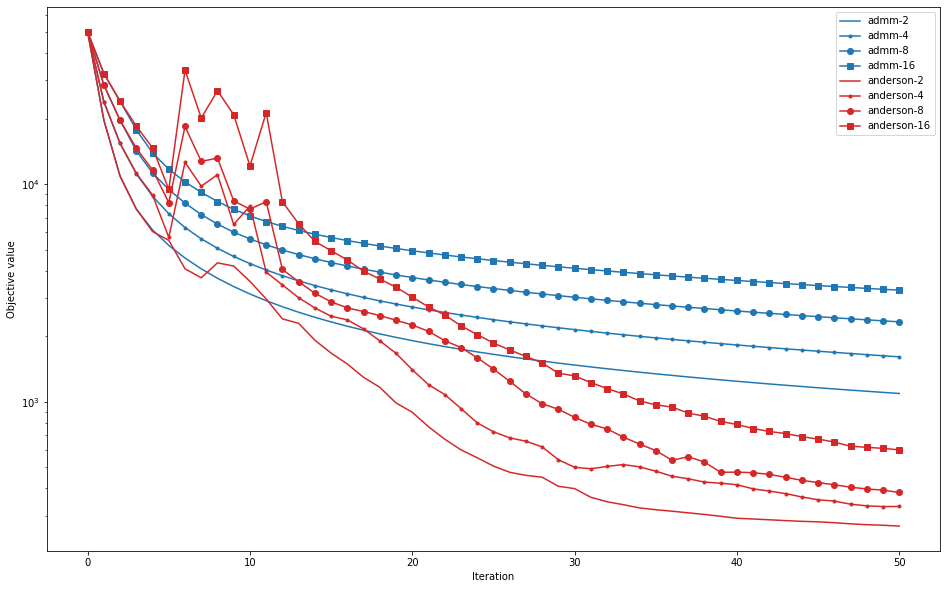

In [18]:
dataset = "real-sim"
optval  = optvals[dataset]
algos = ["admm", "anderson_admm"]
labels = ["admm", "anderson"]
colors = ['C0', 'C3', 'C2', 'C3']
markers = ['', '.', 'o', 's']
fig1 = plt.figure(figsize=(16, 10))
nprocs = [2, 4, 8, 16];
for idx in range(len(algos)):
    for proc_idx in range(len(nprocs)):
        k = []; t = []; 
        f = []; feas = []
        with open("output/"+dataset+ "_" + algos[idx] +"_nprocs"+str(nprocs[proc_idx])+"_rho1.000000"".csv") as csvfile:
            csvReader = csv.reader(csvfile, delimiter=",")
            next(csvReader)  # skip the header
            for row in csvReader:
                k.append(int(row[0]))
                t.append(float(row[1])/60)
                f.append(float(row[2]))
                feas.append(float(row[3]))
        
        plt.plot(k, [f - optval for f in f], color=colors[idx], marker=markers[proc_idx], label=labels[idx]+"-"+str(nprocs[proc_idx]))
        # plt.plot(t, [f - optval for f in f], color=colors[idx], label=labels[idx])
        # plt.plot(k, [fe for fe in feas], color=colors[idx], label=labels[idx])
plt.yscale('log')
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Objective value")

Setting #nprocs=1 yields the accelerated proximal point method. Check the code carefully.

In [15]:
A = np.array([[0.23745072, 1.09557628, 0.99426016, -1.19494335],
              [1.38311306, -0.71729365, 0.93119308, -0.26876015],
              [-0.10427326, -0.58578711, 0.92536737, -0.30543479],
              [0.50070193, -1.79345269, 0.80630967, -0.21159942]])
A = A.T         
b = np.array([-1, 1, -1, -1])   
x = np.array([0.44276126,  0.99440597, -1.02901711,  2.05714234])  
f = LogisticRegression(A,b)
fx, g = f.func_grad(x)
A, b, x, fx, g

In [138]:
A = np.array([[0.23745072, 1.09557628, 0.99426016, -1.19494335],
              [1.38311306, -0.71729365, 0.93119308, -0.26876015],
              [-0.10427326, -0.58578711, 0.92536737, -0.30543479]
            ])
A = A.T     

# A.T.dot(A)

In [140]:
coeff = np.array([-0.089, 1.254, -3.105])
A.dot(coeff)

array([ 2.03705914,  0.82187645, -1.79403872,  0.71769975])

In [ ]:
2.03706  0.821876  -1.79404  0.7177 

In [129]:
z = nla.solve(A.T.dot(A) + 1.515 * np.eye(A.shape[1]), np.ones(A.shape[1]))
z

array([0.14280429, 0.11316464, 0.27447661])

In [ ]:
0.142804  0.113165  0.274477 